In [1]:
cd /mmfs1/data/aglinska/BC-fMRI-AE/Notebooks/

/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks


In [2]:
import numpy as np
import pandas as pd 
import pickle
from helper_funcs import *
from umap import UMAP

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
data_dir = '../Data/latent_vecs/'
files = [file for file in os.listdir(data_dir) if file.startswith('latent')]
files.sort()
[f'{i:02d} | {files[i]}' for i in range(len(files))]

['00 | latent_vecs_CVAE_2021-09-15 14:03:53.826090',
 '01 | latent_vecs_CVAE_2021-09-30 17:08:46.471890',
 '02 | latent_vecs_CVAE_2021-10-06 08:35:55.310173',
 '03 | latent_vecs_CVAE_2021-10-06 17:30:12.802507',
 '04 | latent_vecs_CVAE_2021-10-06 17:30:12.802507_mu',
 '05 | latent_vecs_CVAE_2021-10-06 17:30:12.802507_sigma',
 '06 | latent_vecs_CVAE_2021-10-07 11:03:38.204240',
 '07 | latent_vecs_CVAE_2021-10-20 16:46:49.014573',
 '08 | latent_vecs_CVAE_2021-10-20 16:46:49.014573_mu']

In [4]:
# LOAD LATENT DATA
#analysis_name = 'latent_vecs_CVAE_2021-09-30 17:08:46.471890'
analysis_name = files[7];print(analysis_name)
#data = pickle.load(open('../Data/latent_vecs/latent_vecs_CVAE_2021-09-15 14:03:53.826090','rb'))
data = pickle.load(open(os.path.join(data_dir,analysis_name),'rb'))

latent_vecs_CVAE_2021-10-20 16:46:49.014573


In [5]:
# LOAD DF
df = pd.read_csv('../Data/ABIDE_df.csv')
df = pd.read_csv('../Data/ABIDE_df2.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
patients = df['DX_GROUP'].values==1
df_asd = df.iloc[patients]
len(df)

1048

In [6]:
print(data[list(data.keys())[0]].shape)
print(data['subs'].shape)

(1048,)
(1048,)


In [7]:
# ASSERTS 
nsubs = len(df)
assert len(df['bids_folder'].values)==len(data['subs']), 'diff lenghts'
assert all([df['bids_folder'].values[s]==data['subs'][s] for s in range(nsubs)]), 'out of order'

In [10]:
print(data['BG_ABIDE'].shape)
print(data['SL_ABIDE'].shape)

(10, 1048, 128)
(10, 1048, 16)


In [78]:
data.keys()

dict_keys(['subs', 'BG_ABIDE', 'SL_ABIDE', 'mu_BG_ABIDE', 'mu_SL_ABIDE', 'sigma_BG_ABIDE', 'sigma_SL_ABIDE'])

In [11]:
# Make CMAT

asd_vec_bg = data['BG_ABIDE'][:,patients,:]
asd_vec_sl = data['SL_ABIDE'][:,patients,:]

metric = 'euclidean'
asd_cmat_bg = np.array([make_RDM(data['BG_ABIDE'][i,patients,:],metric=metric) for i in range(10)])
asd_cmat_sl = np.array([make_RDM(data['SL_ABIDE'][i,patients,:],metric=metric) for i in range(10)])

In [12]:
asd_umap_bg = UMAP(n_components=2).fit_transform(asd_vec_bg[0,:,:])
asd_umap_sl = UMAP(n_components=2).fit_transform(asd_vec_sl[0,:,:])

In [26]:
#np.corrcoef(get_triu(asd_cmat_bg[1,:,:]),get_triu(asd_cmat_bg[0,:,:]))[0,1]

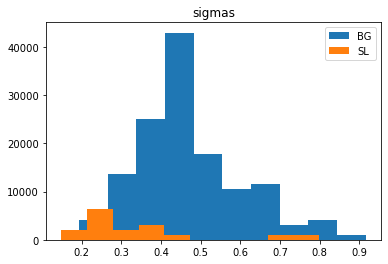

In [77]:
plt.hist((np.e**data['sigma_BG_ABIDE']).flatten());
plt.hist((np.e**data['sigma_SL_ABIDE']).flatten());

plt.title('sigmas')
plt.legend(['BG','SL'])

In [90]:
data['mu_BG_ABIDE'][:,0]

(1048,)

In [95]:
data['mu_BG_ABIDE'][:,10]

array([0.24858803, 0.24858803, 0.24858803, ..., 0.24858803, 0.24858803,
       0.24858803])

array([0.51962371, 0.66239177, 0.12238425, ..., 0.92883667, 0.91013823,
       0.46617451])

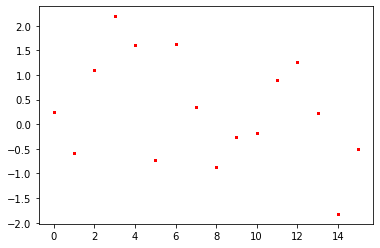

In [117]:
n = data['mu_BG_ABIDE'].shape[0]

xs = np.repeat(0,n)
vec = np.random.rand(n)

#[plt.plot(np.repeat(i,n),data['mu_BG_ABIDE'][:,i],'r.',markersize=3,alpha=.5) for i in range(data['mu_BG_ABIDE'].shape[-1])];
[plt.plot(np.repeat(i,n),data['mu_SL_ABIDE'][:,i],'r.',markersize=3,alpha=.5) for i in range(data['mu_SL_ABIDE'].shape[-1])];

#[plt.plot(np.repeat(i,n),np.random.rand(n),'r.',markersize=3,alpha=.5) for i in range(data['mu_BG_ABIDE'].shape[-1])];

In [36]:
rel_sl = get_triu(np.corrcoef(np.array([get_triu(asd_cmat_sl[i,:,:]) for i in range(10)])))
rel_bg = get_triu(np.corrcoef(np.array([get_triu(asd_cmat_bg[i,:,:]) for i in range(10)])))

Text(0.5, 1.0, 'sample consistency')

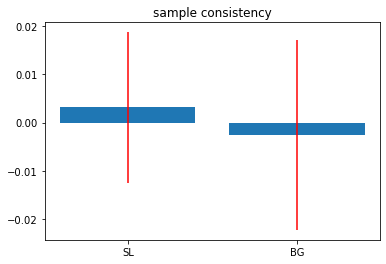

In [43]:
xs = [0,1]
ys = [rel_sl.mean(),rel_bg.mean()]
se = [rel_sl.std(),rel_bg.std()]
plt.bar(xs,ys)
plt.errorbar(xs,ys,se,fmt='r ')
plt.xticks(xs,['SL','BG'])
plt.title('sample consistency')

Text(0.5, 1.0, 'BG-SL corr.')

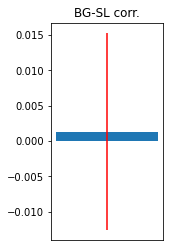

In [13]:
# Correlation between BG and SL
plt.figure(figsize=(2,4))
cross_c = [np.corrcoef(get_triu(asd_cmat_bg[i,:,:]),get_triu(asd_cmat_sl[i,:,:]))[0,1] for i in range(10)]
cross_c = np.array(cross_c)
plt.bar(0,cross_c.mean())
plt.errorbar(0,cross_c.mean(),cross_c.std(),fmt='r ')
plt.xticks([])
plt.title('BG-SL corr.')

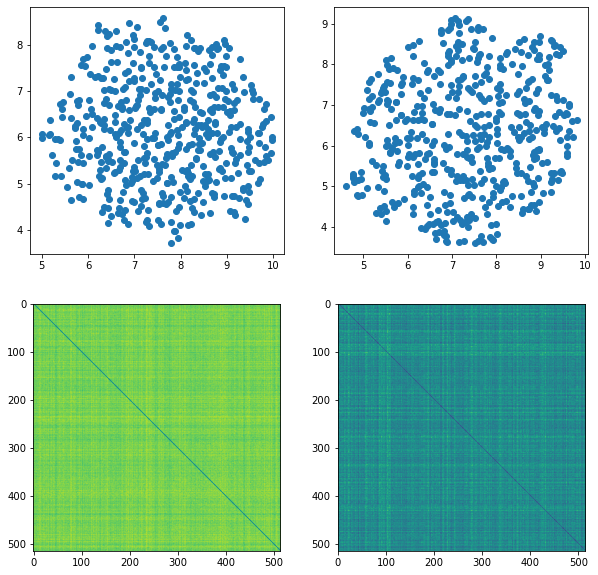

In [14]:
plt.figure(figsize=np.array((5,5))*2    )
plt.subplot(2,2,1)
plt.scatter(asd_umap_bg[:,0],asd_umap_bg[:,1])

plt.subplot(2,2,2)
plt.scatter(asd_umap_sl[:,0],asd_umap_sl[:,1])


plt.subplot(2,2,3)
#plt.scatter(asd_umap_bg[:,0],asd_umap_bg[:,1])
plt.imshow(asd_cmat_bg[0,:,:])

plt.subplot(2,2,4)
plt.imshow(asd_cmat_sl[0,:,:])

In [15]:
def fit_rsa(rsa_data,rsa_model):
    import scipy
    corr = scipy.stats.stats.kendalltau

    assert rsa_data.ndim==3, 'bad data, not 3D'
    assert rsa_data.shape[1]==rsa_data.shape[2], 'not square'
    nsamples = rsa_data.shape[0]
    
    #rsa_data = rsa_data
    #rsa_model = rdm_model

    model_fit = [corr(get_triu(rsa_data[i,:,:]),get_triu(rsa_model[:,:]))[0] for i in range(nsamples)]
    model_fit = np.array(model_fit)
    
    return model_fit

In [64]:
def key_rsa(key,data_scale='ratio', metric='euclidean'):
    initial_slice = patients
    vec = df[key].values[initial_slice]
    sub_slice = ~np.isnan(vec)

    rdm_model = make_RDM(vec[sub_slice],data_scale='ratio', metric='euclidean')
    rdm_bg = np.array([make_RDM(data['BG_ABIDE'][i,initial_slice,:][sub_slice,:],metric='correlation') for i in range(10)])
    rdm_sl = np.array([make_RDM(data['SL_ABIDE'][i,initial_slice,:][sub_slice,:],metric='correlation') for i in range(10)])
    
    #rdm_bg = np.array([make_RDM(data['mu_BG_ABIDE'][initial_slice,:][sub_slice,:]) for i in range(10)])
    #rdm_sl = np.array([make_RDM(data['mu_SL_ABIDE'][initial_slice,:][sub_slice,:]) for i in range(10)])

    rsa_result = np.zeros((2,10))
    rsa_result[0,:] = fit_rsa(rdm_bg,rdm_model)
    rsa_result[1,:] = fit_rsa(rdm_sl,rdm_model)
    return rsa_result

In [65]:
def plot_key_rsa(rsa_result,title=None):
    m = rsa_result.mean(axis=1)
    se = rsa_result.std(axis=1) / 10
    xs = np.arange(len(m)) 
    lbls = ['BG','SL']

    plt.bar(xs,m)
    plt.errorbar(xs,m,se,fmt='r.')
    plt.title(title,fontsize=10)
    plt.xticks(ticks=xs,labels=lbls)

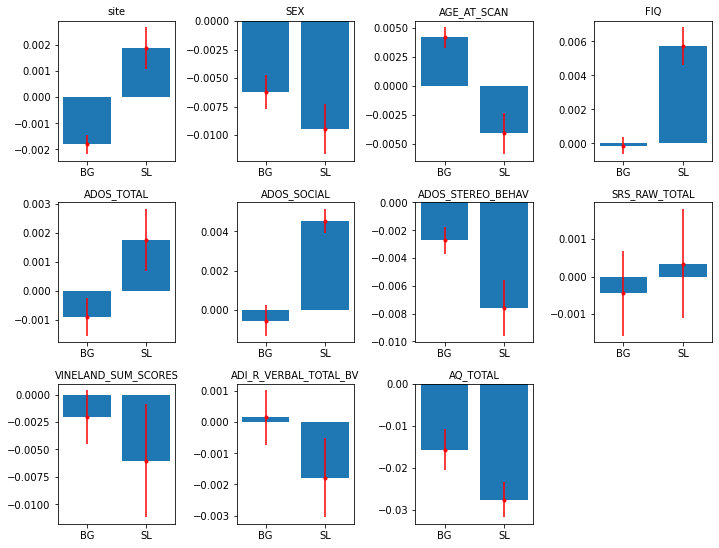

In [66]:
plt.figure(figsize=(10,10));i=0

i+=1;plt.subplot(4,4,i)
key = 'site'
rsa_result = key_rsa(key=key,data_scale='ordinal')
plot_key_rsa(rsa_result,title=key)

i+=1;plt.subplot(4,4,i)
key = 'SEX'
rsa_result = key_rsa(key=key,data_scale='ordinal')
plot_key_rsa(rsa_result,title=key)

i+=1;plt.subplot(4,4,i)
key = 'AGE_AT_SCAN'
rsa_result = key_rsa(key=key,data_scale='ratio')
plot_key_rsa(rsa_result,title=key)

i+=1;plt.subplot(4,4,i)
key = 'FIQ'
rsa_result = key_rsa(key=key,data_scale='ratio')
plot_key_rsa(rsa_result,title=key)

i+=1;plt.subplot(4,4,i)
key = 'ADOS_TOTAL'
rsa_result = key_rsa(key=key,data_scale='ratio')
plot_key_rsa(rsa_result,title=key)


i+=1;plt.subplot(4,4,i)
key = 'ADOS_SOCIAL'
rsa_result = key_rsa(key=key,data_scale='ratio')
plot_key_rsa(rsa_result,title=key)


i+=1;plt.subplot(4,4,i)
key = 'ADOS_STEREO_BEHAV'
rsa_result = key_rsa(key=key,data_scale='ratio')
plot_key_rsa(rsa_result,title=key)

i+=1;plt.subplot(4,4,i)
key = 'SRS_RAW_TOTAL'
rsa_result = key_rsa(key=key,data_scale='ratio')
plot_key_rsa(rsa_result,title=key)


i+=1;plt.subplot(4,4,i)
key = 'VINELAND_SUM_SCORES'
rsa_result = key_rsa(key=key,data_scale='ratio')
plot_key_rsa(rsa_result,title=key)


i+=1;plt.subplot(4,4,i)
key = 'ADI_R_VERBAL_TOTAL_BV'
rsa_result = key_rsa(key=key,data_scale='ratio')
plot_key_rsa(rsa_result,title=key)


i+=1;plt.subplot(4,4,i)
key = 'AQ_TOTAL'
rsa_result = key_rsa(key=key,data_scale='ratio')
plot_key_rsa(rsa_result,title=key)


plt.tight_layout()

In [67]:
keys = ['site','SEX','AGE_AT_SCAN','FIQ','ADOS_TOTAL','ADOS_SOCIAL','ADOS_STEREO_BEHAV','SRS_RAW_TOTAL','VINELAND_SUM_SCORES','ADI_R_VERBAL_TOTAL_BV','AQ_TOTAL']

In [58]:
import scipy
corr = scipy.stats.stats.kendalltau

In [59]:
vec_behav = df_asd['ADOS_TOTAL'].values

v = ~np.isnan(vec_behav)
vec_behav = vec_behav[v]
vec_sl_1 = asd_umap_sl[v,0]
vec_sl_2 = asd_umap_sl[v,1]
vec_bg_1 = asd_umap_bg[v,0]
vec_bg_2 = asd_umap_bg[v,1]

In [60]:
c,p = corr(vec_behav,vec_sl_1)

In [61]:
columns=[('BG', 'r'), ('BG', 'p'), ('SL', 'r'), ('SL', 'p')]
a = pd.DataFrame(np.zeros((10,4)))
a.columns = pd.MultiIndex.from_tuples(columns)
a

BG        SL     
     r    p    r    p
0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0
6  0.0  0.0  0.0  0.0
7  0.0  0.0  0.0  0.0
8  0.0  0.0  0.0  0.0
9  0.0  0.0  0.0  0.0

In [38]:
df.columns

Index(['participant_id', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN', 'SEX',
       'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ',
       'FIQ_TEST_TYPE', 'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE',
       'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C',
       'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE',
       'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV',
       'ADOS_RSRCH_RELIABLE', 'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB',
       'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION',
       'SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION',
       'SRS_MOTIVATION', 'SRS_MANNERISMS', 'SCQ_TOTAL', 'AQ_TOTAL',
       'COMORBIDITY', 'CURRENT_MED_STATUS', 'MEDICATION_NAME',
       'OFF_STIMULANTS_AT_SCAN', 'VINELAND_RECEPTIVE_V_SCALED',
       'VINELAND_EXPRESSIVE_V_SCALED', 'VINELAND_WRITTEN_V_SCALED',
       'VINELAND_COMMUNICATION_STANDARD', 'VINELAND_PERSONAL_V_SCALED',
       'VINELAND_DOMESTIC_V_S